# Log File Anomaly Detection

**Company Use Case:**

Due to the potential presence of sensitive patient data, log files cannot be shared or processed on the cloud directly. Homomorphic encryption comes into play by encrypting the log files and enabling predictive filtering of sensitive lines within them. This approach ensures data privacy while allowing for the extraction of valuable insights, particularly beneficial for enhancing predictive maintenance efforts.

**Approach:**

Since it's unknown which sensitive information could be contained in the log files the goal is to implement an anomaly detection algorithm which is trained on "normal samples" (_notice_ & _warn_ logs)

The following Notebook will show two approaches to do this with ConcreteML.

**Dataset Source:**

The data used is provided by Loghub, which maintains a collection of system logs that are freely accessible for AI-driven log analytics research . The logs are a combination of production data released from previous studies and real systems in their lab environment. The logs are not sanitized, anonymized, or modified in any way, wherever possible. These log datasets are freely available for research or academic work.

https://github.com/logpai/loghub/tree/master

**Dataset  1:**

_Android_

Loghub Description:

Android (https://www.android.com) is a popular open-source mobile operating system and has been used by many smart devices. However, Android logs are rarely available in public for research purposes. We provide some Android log files, which were collected by Android smartphones with heavily instrumented modules installed. The Android architecture comprises of five levels, including the Linux Kernel, Libraries, Application Framework, Android Runtime, and System Applications. We provide a sample log file printed by the Application Framework.

Training on logs: [Info (I), Debug (D), Verbose (V)]

Test detecting: [Warn (W), Error (E)]

https://github.com/logpai/loghub/blob/master/Android/Android_2k.log_structured.csv

**Dataset 2:**

_BGL_

Loghub Description:

BGL is an open dataset of logs collected from a BlueGene/L supercomputer system at Lawrence Livermore National Labs (LLNL) in Livermore, California, with 131,072 processors and 32,768GB memory. The log contains alert and non-alert messages identified by alert category tags. In the first column of the log, "-" indicates non-alert messages while others are alert messages. The label information is amenable to alert detection and prediction research. It has been used in several studies on log parsing, anomaly detection, and failure prediction.

Training on logs: [Info, Warning]

Test detecting: [Error, Fatal, Severe]

https://github.com/logpai/loghub/blob/master/BGL/BGL_2k.log_structured.csv

**Dataset 3:**

_Hadoop_

Loghub Description:

Hadoop is a big data processing framework that allows for the distributed processing of large data sets across clusters of computers using simple programming models.The logs are generated from a Hadoop cluster with 46 cores across five machines simulating both normal and abnormal cases with injected specific failures for two applications (WordCount & PageRank)

Training on logs: [Info, Warn]

Test detecting: [Error, Fatal]

https://github.com/logpai/loghub/blob/master/Hadoop/Hadoop_2k.log_structured.csv

# FHE Mode

In [1]:
fhe_mode = 'execute'

# Imports

In [2]:
import time
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Scikit-Learn
from sklearn.svm import OneClassSVM
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import *

# XGBoost
from xgboost.sklearn import XGBClassifier

# Concrete ML
import concrete.ml as cml
from concrete.ml.sklearn import XGBClassifier as ConcreteXGBClassifier
from concrete.ml.sklearn import NeuralNetRegressor as ConcreteMLPRegressor

# PyTorch
import torch

In [3]:
# assert ConcreteML version 1.3.0
assert cml.__version__ == '1.3.0', 'ConcreteML version 1.3.0 required'
# # # print ConcreteML version
print(f'ConcreteML Version: {cml.__version__}')

ConcreteML Version: 1.3.0


In [4]:
# set random seed
np.random.seed(42)
torch.manual_seed(42)

# Plot Functions

In [5]:
def plot_classification_metrics(
    y_true: np.array,
    y_pred: np.array,
    plot_title: str = None
    ):

    '''
    Plots Classification Metrics

    Input:
      y_true = ground truth labels
      y_pred = prediction labels
      plot_title = title for results plot (optional)
    '''

    fig, ax = plt.subplots(2, 1, figsize=(5, 5))
    ax = ax.flatten()

    if len(np.unique(y_true)) == 2:
        accuracy = round(accuracy_score(y_true, y_pred),2)
        precision = round(precision_score(y_true, y_pred),2)
        recall = round(recall_score(y_true, y_pred),2)
        f1 = round(f1_score(y_true, y_pred),2)
        ax[0].bar(['Accuracy', 'Precision', 'Recall', 'F1'], [accuracy, precision, recall, f1])
    else:
        accuracy = round(accuracy_score(y_true, y_pred),2)
        precision = round(precision_score(y_true, y_pred, average='macro'),2)
        recall = round(recall_score(y_true, y_pred, average='macro'),2)
        f1 = round(f1_score(y_true, y_pred, average='macro'),2)
        ax[0].bar(['Accuracy', 'Precision', 'Recall', 'F1'], [accuracy, precision, recall, f1])


    # barchart of metrics for each classifier
    ax[0].set_title('Classifier Metrics')
    ax[0].set_ylim(0,1)
    ax[0].bar_label(ax[0].containers[0], label_type='center')

    # confusion matrix for each classifier
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm).plot(ax=ax[1], cmap='Blues', colorbar=False)
    ax[1].set_title('Classifier Confusion Matrix')

    plt.suptitle(plot_title)
    plt.tight_layout()

    plt.show()

# Load Data

In [6]:
data_android = np.load('../Data/Android.npz')
xtrain_android, xval_android, xtest_android = data_android['xtrain'], data_android['xval'], data_android['xtest']
yval_android, ytest_android = data_android['yval'], data_android['ytest']

In [7]:
data_bgl = np.load('../Data/Bgl.npz')
xtrain_bgl, xval_bgl, xtest_bgl = data_bgl['xtrain'], data_bgl['xval'], data_bgl['xtest']
yval_bgl, ytest_bgl = data_bgl['yval'], data_bgl['ytest']

In [8]:
data_hadoop = np.load('../Data/Hadoop.npz')
xtrain_hadoop, xval_hadoop, xtest_hadoop = data_hadoop['xtrain'], data_hadoop['xval'], data_hadoop['xtest']
yval_hadoop, ytest_hadoop = data_hadoop['yval'], data_hadoop['ytest']

# Modelling

## Approach 1: OneClassSVM & XGBoost

ConcreteML lacks support for "One Class Classification". To address this limitation, a potential workaround involves initially training an OneClassSVM from the Scikit-learn library to generate anomaly labels. These labels can then serve as the classifier target for training an XGBClassifier, which can operate in conjunction with ConcreteML, allowing for the utilization of homomorphic encryption while accommodating the absence of direct support for One Class Classification within ConcreteML.
<br></br>
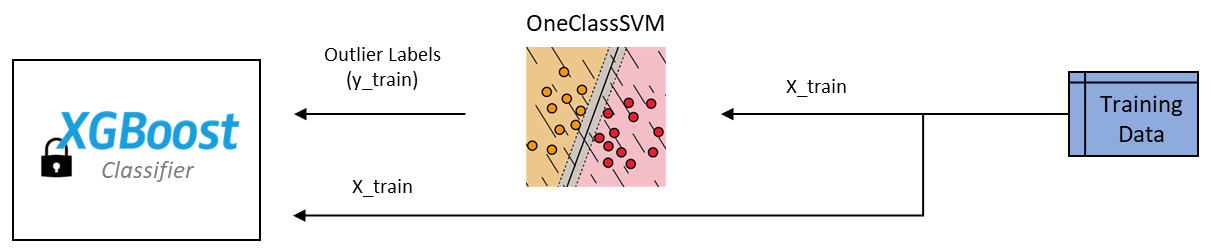

In [9]:
# For fairness, we use the same hyperparameters for both the XGBoost and ConcreteXGBClassifier
xgb_hyperparams = XGBClassifier().get_params()
concrete_xgb_hyperparams = ConcreteXGBClassifier().get_params()

# Shared hyperparameters with default values of the ConcreteXGBClassifier
shared_hyperparams = {key: concrete_xgb_hyperparams[key] for key in xgb_hyperparams if key in concrete_xgb_hyperparams}

### XGBoost

In [10]:
class XGBoostAnomalyDetector():
    
    def __init__(self, xgb_params=None):
        self.oneclassmodel = OneClassSVM()
        if xgb_params is not None:
            self.classifier = XGBClassifier(**xgb_params)
        else:
            self.classifier = XGBClassifier()
        self.log = {
            'train': None,
            'evaluate_total': None,
            'evaluate_sample': None,
            'accuracy': None,
            'precision': None,
            'recall': None,
            'f1': None,
        }

    def train(self, X):
        # to numpy array
        X = np.array(X)
        # fit one-class model
        start_time = time.time()
        self.oneclassmodel.fit(X)
        # create y_train
        y_train = np.where(self.oneclassmodel.predict(X)==-1, 1, 0)
        # fit classifier
        self.classifier.fit(X, y_train)
        self.log['train'] = time.time() - start_time

        return self
    
    def evaluate(self, X, y_true):
        # to numpy array
        X = np.array(X)
        # predict
        start_time = time.time()
        y_pred = np.array([self.classifier.predict(X[[i]])[0] for i in tqdm(range(X.shape[0]))])
        self.log['evaluate_total'] = time.time() - start_time
        self.log['evaluate_sample'] = self.log['evaluate_total']/X.shape[0]
        # calculate metrics
        self.log['accuracy'] = round(accuracy_score(y_true, y_pred), 2)
        self.log['precision'] = round(precision_score(y_true, y_pred), 2)
        self.log['recall'] = round(recall_score(y_true, y_pred), 2)
        self.log['f1'] = round(f1_score(y_true, y_pred), 2)
        # plot
        plot_classification_metrics(y_true, y_pred, plot_title='XGBoost Anomaly Detector')
        # return prediction labels
        return y_pred

#### Android Dataset

100%|██████████| 100/100 [00:00<00:00, 277.09it/s]


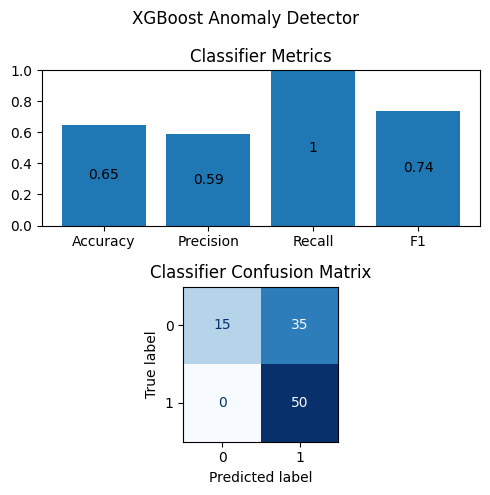

In [11]:
# initialize model
xgboost_anomaly_detector = XGBoostAnomalyDetector(xgb_params=shared_hyperparams)
# train model
xgboost_anomaly_detector = xgboost_anomaly_detector.train(xtrain_android)
# evaluate model
ypred_xgboost = xgboost_anomaly_detector.evaluate(xtest_android, ytest_android)

In [12]:
# display results
results = pd.DataFrame(xgboost_anomaly_detector.log, index=[0])
results

,train,evaluate_total,evaluate_sample,accuracy,precision,recall,f1
0,1.194799,0.363366,0.003634,0.65,0.59,1.0,0.74


#### BGL Dataset

100%|██████████| 100/100 [00:00<00:00, 128.83it/s]


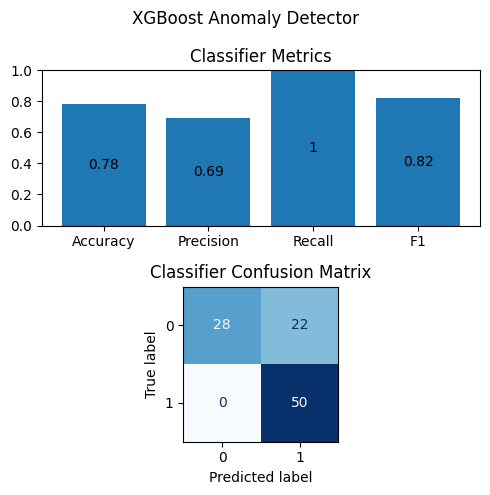

In [13]:
# initialize model
xgboost_anomaly_detector = XGBoostAnomalyDetector(xgb_params=shared_hyperparams)
# train model
xgboost_anomaly_detector = xgboost_anomaly_detector.train(xtrain_bgl)
# evaluate model
ypred_xgboost = xgboost_anomaly_detector.evaluate(xtest_bgl, ytest_bgl)

In [14]:
# display results
results = pd.DataFrame(xgboost_anomaly_detector.log, index=[0])
results

,train,evaluate_total,evaluate_sample,accuracy,precision,recall,f1
0,0.772799,0.78393,0.007839,0.78,0.69,1.0,0.82


#### Hadoop Dataset

100%|██████████| 100/100 [00:00<00:00, 221.78it/s]


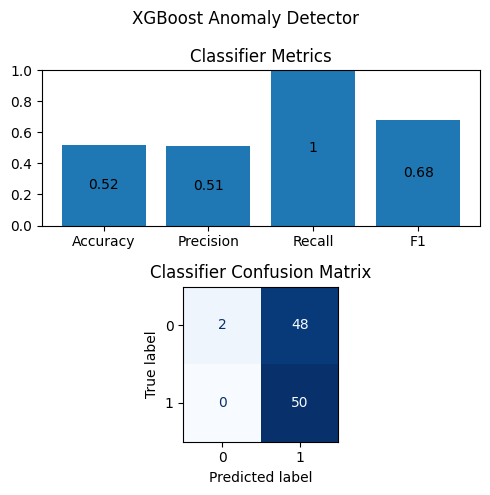

In [15]:
# initialize model
xgboost_anomaly_detector = XGBoostAnomalyDetector(xgb_params=shared_hyperparams)
# train model
xgboost_anomaly_detector = xgboost_anomaly_detector.train(xtrain_hadoop)
# evaluate model
ypred_xgboost = xgboost_anomaly_detector.evaluate(xtest_hadoop, ytest_hadoop)

In [16]:
# display results
results = pd.DataFrame(xgboost_anomaly_detector.log, index=[0])
results

,train,evaluate_total,evaluate_sample,accuracy,precision,recall,f1
0,0.801976,0.455597,0.004556,0.52,0.51,1.0,0.68


### Concrete

In [17]:
class ConcreteAnomalyDetector():

    def __init__(self, n_bits=2, xgb_params=None):
        self.n_bits = n_bits
        self.oneclassmodel = OneClassSVM()
        if xgb_params is not None:
            self.classifier = ConcreteXGBClassifier(n_bits=n_bits, **xgb_params)
        else:
            self.classifier = ConcreteXGBClassifier(n_bits=n_bits)
        self.fhe_circuit = None
        self.log = {
            'n_bits': n_bits,
            'train': None,
            'compile': None,
            'keygen': None,
            'evaluate_total': None,
            'evaluate_sample': None,
            'accuracy': None,
            'precision': None,
            'recall': None,
            'f1': None,
        }

    def train(self, X):
        # to numpy array
        X = np.array(X)
        # start timer
        start_time = time.time()
        # fit one-class model
        self.oneclassmodel.fit(X)
        # create y_train
        y_train = np.where(self.oneclassmodel.predict(X)==-1, 1, 0)
        # fit classifier
        self.classifier = self.classifier.fit(X, y_train)
        self.log['train'] = time.time() - start_time
        # compile concrete model
        start_time = time.time()
        self.fhe_circuit = self.classifier.compile(X[:100])
        self.log['compile'] = time.time() - start_time

        return self
    
    def evaluate(self, X, y_true, fhe='simulate'):
        # to numpy array
        X = np.array(X)
        # key generation
        start_time = time.time()
        self.fhe_circuit.keygen(force=True)
        self.log['keygen'] = time.time() - start_time
        # predict
        start_time = time.time()
        y_pred = np.array([self.classifier.predict(X[[i]], fhe=fhe)[0] for i in tqdm(range(X.shape[0]))])
        self.log['evaluate_total'] = time.time() - start_time
        self.log['evaluate_sample'] = self.log['evaluate_total']/X.shape[0]
        # calculate metrics
        self.log['accuracy'] = round(accuracy_score(y_true, y_pred), 2)
        self.log['precision'] = round(precision_score(y_true, y_pred), 2)
        self.log['recall'] = round(recall_score(y_true, y_pred), 2)
        self.log['f1'] = round(f1_score(y_true, y_pred), 2)
        # plot
        plot_classification_metrics(y_true, y_pred, plot_title=f'Concrete Anomaly Detector (n_bits={self.n_bits})')
        # return prediction labels
        return y_pred

#### Android Dataset

100%|██████████| 50/50 [00:00<00:00, 114.73it/s]


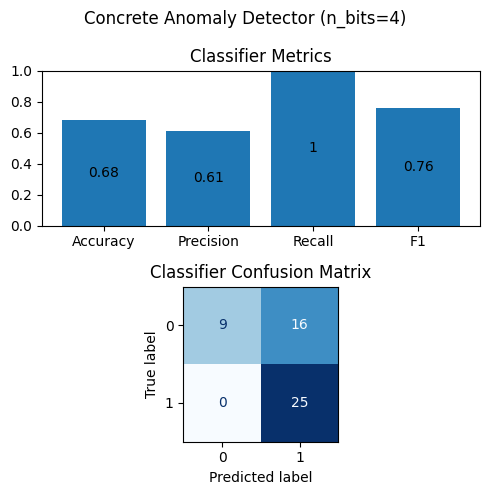

In [18]:
# fine-tune model

# initialize model
concrete_anomaly_detector = ConcreteAnomalyDetector(n_bits=4, xgb_params=shared_hyperparams)

# train model
concrete_anomaly_detector = concrete_anomaly_detector.train(xtrain_android)

# evaluate model on validation set
ypred_concrete = concrete_anomaly_detector.evaluate(xval_android, yval_android, fhe='simulate')

100%|██████████| 100/100 [01:23<00:00,  1.20it/s]


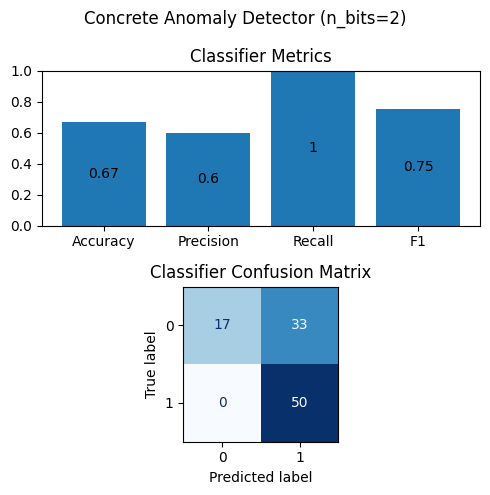

100%|██████████| 100/100 [01:30<00:00,  1.10it/s]


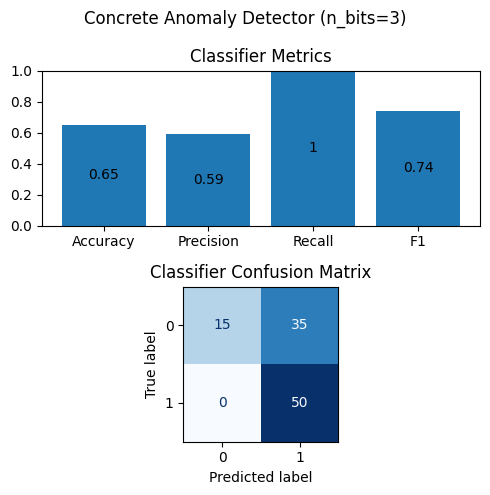

100%|██████████| 100/100 [01:34<00:00,  1.06it/s]


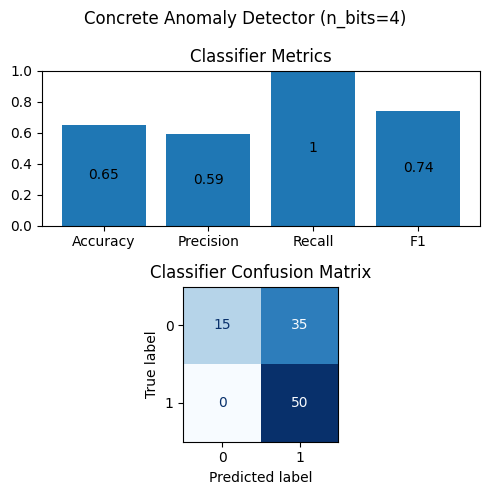

100%|██████████| 100/100 [02:56<00:00,  1.77s/it]


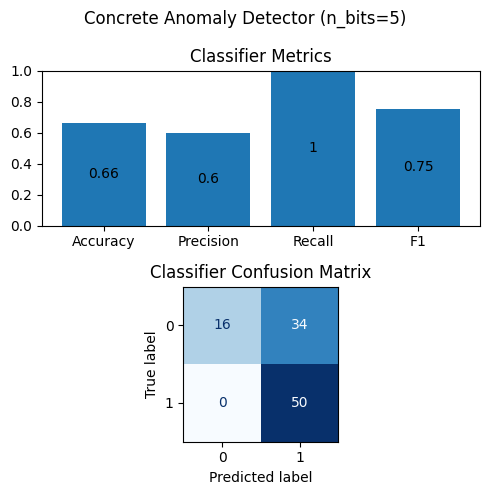

100%|██████████| 100/100 [05:54<00:00,  3.54s/it]


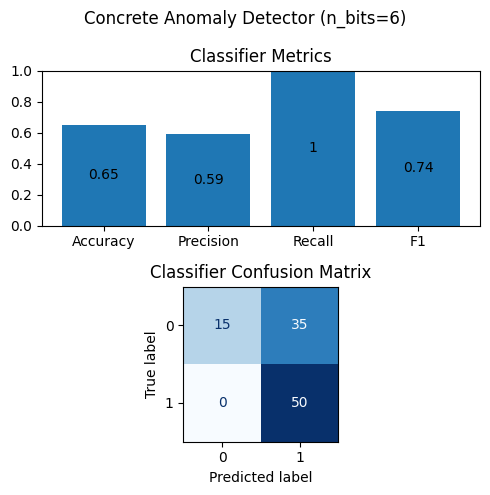

In [19]:
results = []

for n_bits in range(2,7):
    # initialize model
    concrete_anomaly_detector = ConcreteAnomalyDetector(n_bits=n_bits, xgb_params=shared_hyperparams)
    # train model
    concrete_anomaly_detector = concrete_anomaly_detector.train(xtrain_android)
    # evaluate model
    ypred_concrete = concrete_anomaly_detector.evaluate(xtest_android, ytest_android, fhe=fhe_mode)
    # append results to list
    results.append(concrete_anomaly_detector.log)

In [20]:
# display results
results = pd.DataFrame(results)
results

,n_bits,train,compile,keygen,evaluate_total,evaluate_sample,accuracy,precision,recall,f1
0,2,1.836375,0.305081,1.237735,83.539678,0.835397,0.67,0.60,1.0,0.75
1,3,1.604602,0.289726,1.304237,90.953260,0.909533,0.65,0.59,1.0,0.74
2,4,1.606470,0.395004,2.760525,94.165075,0.941651,0.65,0.59,1.0,0.74
3,5,1.945570,0.450834,7.227156,176.883682,1.768837,0.66,0.60,1.0,0.75
4,6,2.000551,0.483444,28.983484,354.106993,3.541070,0.65,0.59,1.0,0.74


#### BGL Dataset

100%|██████████| 50/50 [00:00<00:00, 139.18it/s]


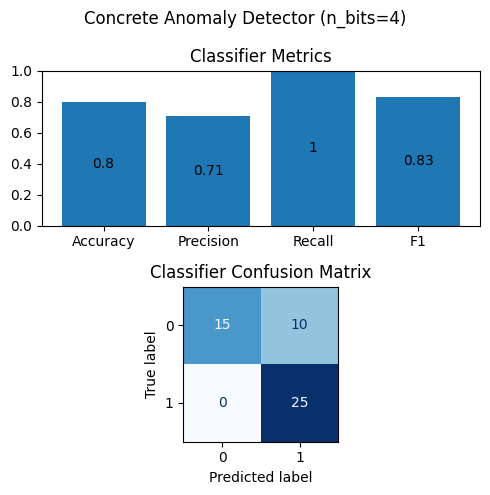

In [21]:
# fine-tune model

# initialize model
concrete_anomaly_detector = ConcreteAnomalyDetector(n_bits=4, xgb_params=shared_hyperparams)

# train model
concrete_anomaly_detector = concrete_anomaly_detector.train(xtrain_bgl)

# evaluate model on validation set
ypred_concrete = concrete_anomaly_detector.evaluate(xval_bgl, yval_bgl, fhe='simulate')

100%|██████████| 100/100 [00:42<00:00,  2.33it/s]


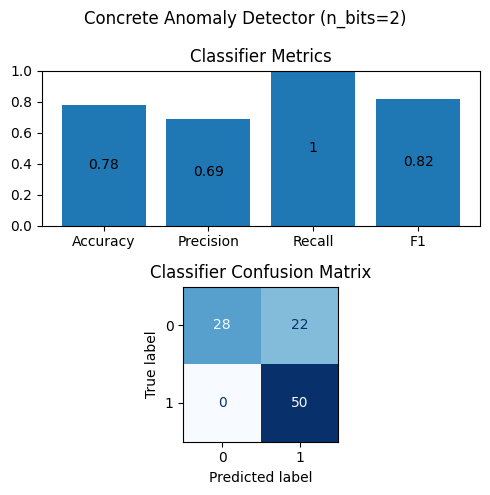

100%|██████████| 100/100 [00:42<00:00,  2.37it/s]


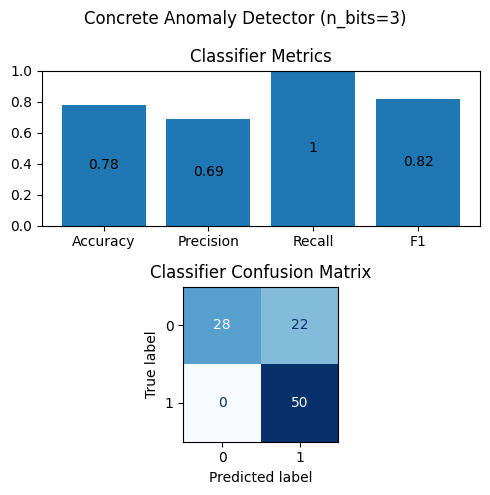

100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


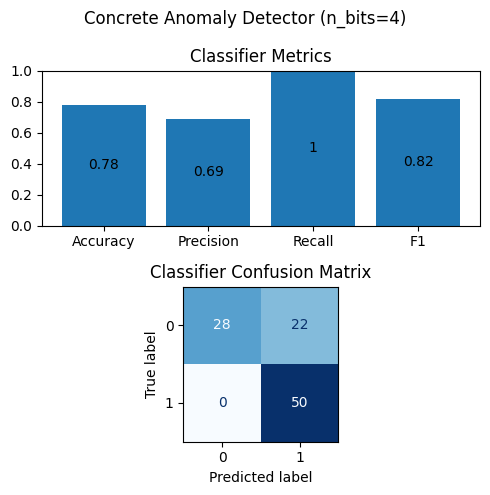

100%|██████████| 100/100 [01:24<00:00,  1.18it/s]


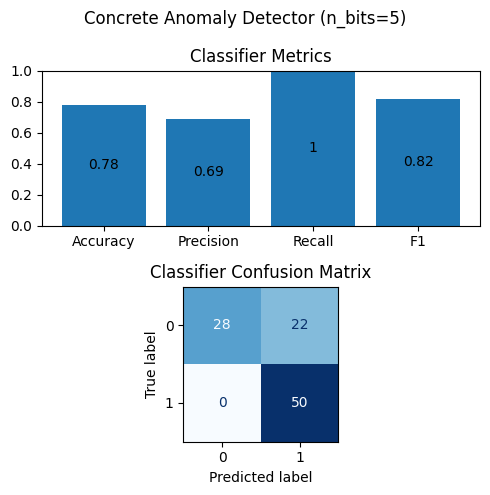

100%|██████████| 100/100 [03:29<00:00,  2.10s/it]


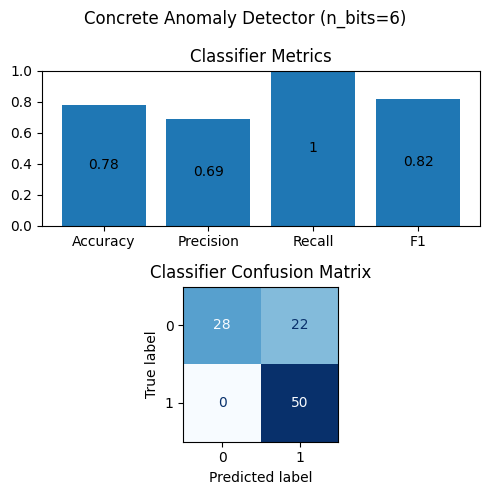

In [22]:
results = []

for n_bits in range(2,7):
    # initialize model
    concrete_anomaly_detector = ConcreteAnomalyDetector(n_bits=n_bits, xgb_params=shared_hyperparams)
    # train model
    concrete_anomaly_detector = concrete_anomaly_detector.train(xtrain_bgl)
    # evaluate model
    ypred_concrete = concrete_anomaly_detector.evaluate(xtest_bgl, ytest_bgl, fhe=fhe_mode)
    # append results to list
    results.append(concrete_anomaly_detector.log)

In [23]:
# display results
results = pd.DataFrame(results)
results

,n_bits,train,compile,keygen,evaluate_total,evaluate_sample,accuracy,precision,recall,f1
0,2,0.935845,0.340320,1.451113,42.915017,0.429150,0.78,0.69,1.0,0.82
1,3,0.641016,0.252924,1.240409,42.258314,0.422583,0.78,0.69,1.0,0.82
2,4,0.663838,0.341506,2.770194,48.596671,0.485967,0.78,0.69,1.0,0.82
3,5,0.714109,0.391091,7.463413,84.605268,0.846053,0.78,0.69,1.0,0.82
4,6,0.641511,0.330418,27.019169,209.616934,2.096169,0.78,0.69,1.0,0.82


#### Hadoop Dataset

100%|██████████| 50/50 [00:00<00:00, 160.05it/s]


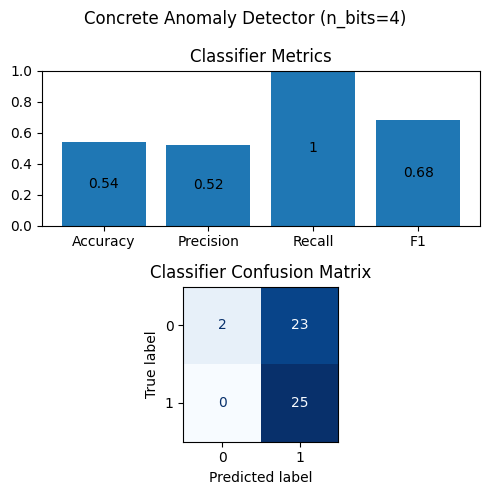

In [24]:
# fine-tune model

# initialize model
concrete_anomaly_detector = ConcreteAnomalyDetector(n_bits=4, xgb_params=shared_hyperparams)

# train model
concrete_anomaly_detector = concrete_anomaly_detector.train(xtrain_hadoop)

# evaluate model on validation set
ypred_concrete = concrete_anomaly_detector.evaluate(xval_hadoop, yval_hadoop, fhe='simulate')

100%|██████████| 100/100 [00:42<00:00,  2.35it/s]


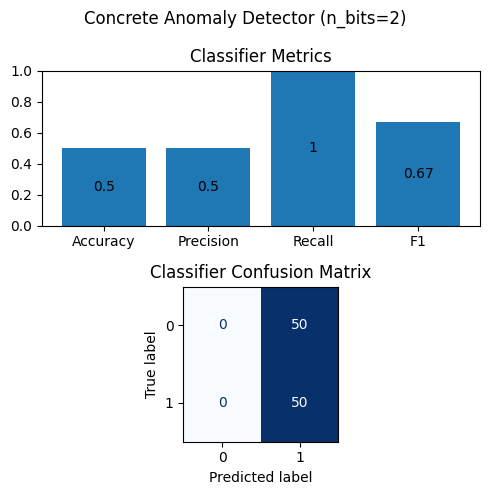

100%|██████████| 100/100 [00:41<00:00,  2.40it/s]


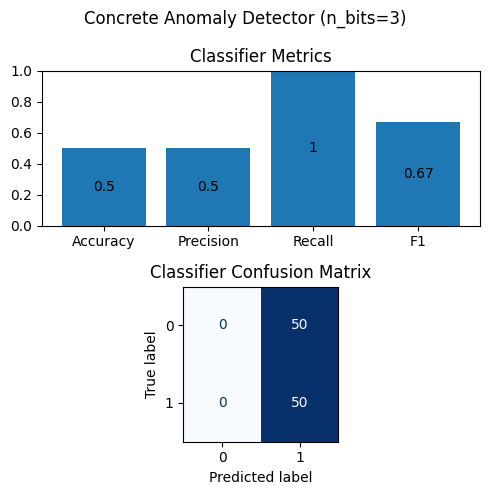

100%|██████████| 100/100 [00:50<00:00,  2.00it/s]


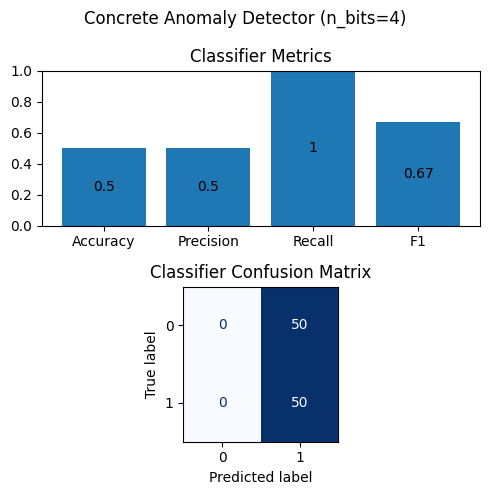

100%|██████████| 100/100 [01:25<00:00,  1.18it/s]


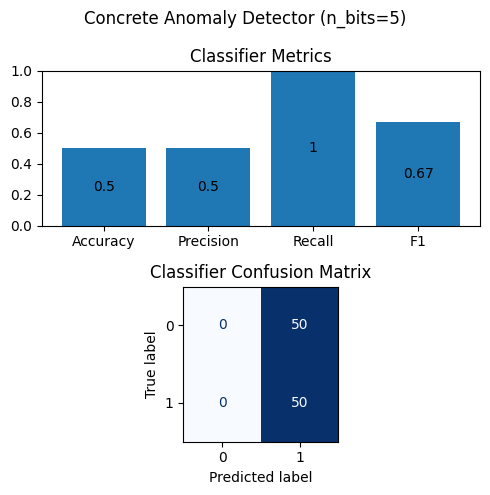

100%|██████████| 100/100 [03:32<00:00,  2.12s/it]


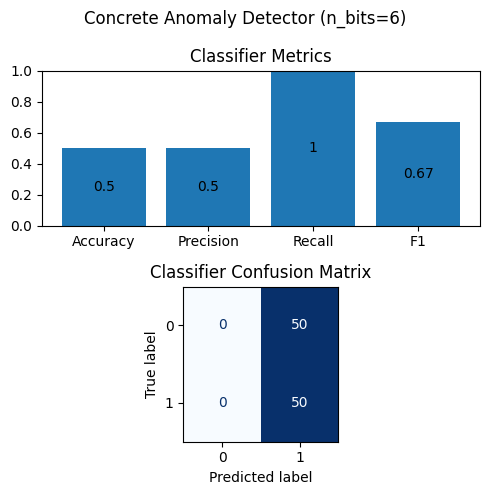

In [25]:
results = []

for n_bits in range(2,7):
    # initialize model
    concrete_anomaly_detector = ConcreteAnomalyDetector(n_bits=n_bits, xgb_params=shared_hyperparams)
    # train model
    concrete_anomaly_detector = concrete_anomaly_detector.train(xtrain_hadoop)
    # evaluate model
    ypred_concrete = concrete_anomaly_detector.evaluate(xtest_hadoop, ytest_hadoop, fhe=fhe_mode)
    # append results to list
    results.append(concrete_anomaly_detector.log)

In [26]:
# display results
results = pd.DataFrame(results)
results

,n_bits,train,compile,keygen,evaluate_total,evaluate_sample,accuracy,precision,recall,f1
0,2,0.820587,0.243429,1.300291,42.645278,0.426453,0.5,0.5,1.0,0.67
1,3,0.790933,0.224811,1.269780,41.585860,0.415859,0.5,0.5,1.0,0.67
2,4,0.773845,0.347011,2.732572,50.051418,0.500514,0.5,0.5,1.0,0.67
3,5,0.771025,0.351447,7.421934,85.100810,0.851008,0.5,0.5,1.0,0.67
4,6,0.993703,0.381895,26.559435,212.201795,2.122018,0.5,0.5,1.0,0.67
